In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
from PIL import Image
from tensorflow.keras.optimizers import Adam
import os
##from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow.keras.regularizers import l2
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import Model

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [ ]:
def preprocess_image(image, label):
    image = tf.keras.applications.vgg19.preprocess_input(image)

    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

    return image, label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/"

'Colab Notebooks'   Dataset1.zip   dataset3.zip   dataset.zip
 dataset_1.zip	    Dataset2.zip   dataset4.zip   fake_news_dataset.zip


In [ ]:
import zipfile

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/drive/My Drive/Dataset1.zip'
extraction_path = '/content/Dataset'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
dataset_path = "/content/Dataset/Blood cell Cancer [ALL]"

In [ ]:
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
).map(preprocess_image)
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
subset_size = int(1.0 * dataset_size)

# Take 20% of the dataset
dataset = full_dataset.take(subset_size)

Found 3242 files belonging to 4 classes.


In [ ]:
class_names = sorted(os.listdir(dataset_path))

print(class_names)

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']


In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 128, 128, 3)
[3 3 2 2 1 2 0 0 3 0 2 0 2 0 0 3]


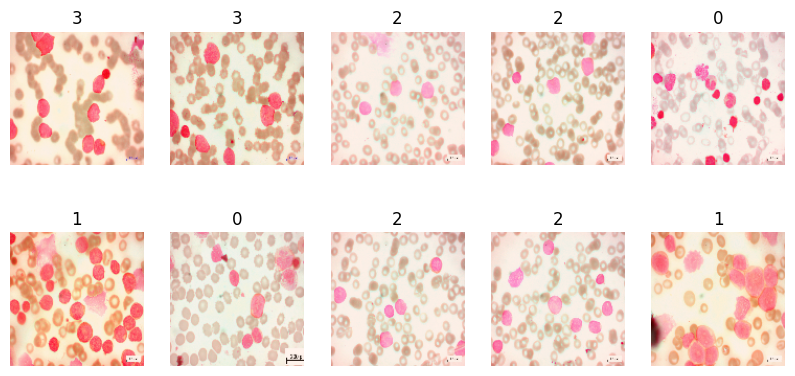

In [ ]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))

    num_images = min(10, images.shape[0])

    for i in range(num_images):
        ax = plt.subplot(4, 5, i + 1)
        img = images[i].numpy()

        if img.min() < 0 or img.max() > 1:
            img = ((img - img.min()) / (img.max() - img.min()) * 255).astype("uint8")
        else:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")

    plt.show()
    break

In [ ]:
len(dataset)

203

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

142

In [ ]:
len(val_ds)

30

In [ ]:
len(test_ds)

31

In [ ]:
def custom_augmentation(image, label):

    # Random flip
    image = tf.image.random_flip_left_right(image)

    #Random brightness and contrast adjustment
    # image = tf.image.random_brightness(image, max_delta=0.1)
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.0)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

train_ds = train_ds.map(custom_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, multiply

# def se_block(input_tensor, reduction_ratio=8):
#     """ Squeeze-and-Excitation Block """
#     channels = input_tensor.shape[-1]  # Number of channels
#     se = GlobalAveragePooling2D()(input_tensor)  # Squeeze operation
#     se = Dense(channels // reduction_ratio, activation='relu')(se)  # Bottleneck layer
#     se = Dense(channels, activation='sigmoid')(se)  # Scale each channel
#     se = Reshape((1, 1, channels))(se)  # Reshape to broadcast
#     return multiply([input_tensor, se])  # Recalibrate the feature maps

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import pandas as pd

# Base components
def cbam_block(x, ratio=8):
    channel = x.shape[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')
    shared_dense_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal')

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([x, channel_attention])

    # Spatial Attention
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

# Channel attention only
def channel_attention_only(x, ratio=8):
    channel = x.shape[-1]

    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')
    shared_dense_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal')

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([x, channel_attention])

    return x

# Spatial attention only
def spatial_attention_only(x):
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

# Residual block variations
def residual_block(x, filters, attention_type='cbam', use_residual=True):
    if use_residual:
        shortcut = x
        if x.shape[-1] != filters:
            shortcut = Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(shortcut)
            shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    if use_residual:
        x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Apply attention based on type
    if attention_type == 'cbam':
        x = cbam_block(x)
    elif attention_type == 'channel':
        x = channel_attention_only(x)
    elif attention_type == 'spatial':
        x = spatial_attention_only(x)
    # elif attention_type == 'none': no attention applied

    return x

# Plain conv block (no residual, no attention)
def conv_block(x, filters):
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# Ablation study model builder
def build_ablation_model(input_shape, num_classes, config):
    """
    config = {
        'attention_type': 'cbam'/'channel'/'spatial'/'none',
        'use_residual': True/False,
        'use_dropout': True/False,
        'use_l2_reg': True/False,
        'dense_layers': [512, 256] or [256] or [512],
        'dropout_rates': [0.4, 0.3] or [0.5] etc.
    }
    """
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2))(x)

    # Apply different block types based on config
    if config['use_residual']:
        x = residual_block(x, 64, config['attention_type'])
        x = MaxPooling2D((2,2))(x)

        x = residual_block(x, 128, config['attention_type'])
        x = MaxPooling2D((2,2))(x)

        x = residual_block(x, 256, config['attention_type'])
        x = MaxPooling2D((2,2))(x)

        x = residual_block(x, 512, config['attention_type'])
    else:
        # Use plain conv blocks
        x = conv_block(x, 64)
        x = MaxPooling2D((2,2))(x)

        x = conv_block(x, 128)
        x = MaxPooling2D((2,2))(x)

        x = conv_block(x, 256)
        x = MaxPooling2D((2,2))(x)

        x = conv_block(x, 512)

    x = GlobalAveragePooling2D()(x)

    # Dense layers with ablation options
    for i, units in enumerate(config['dense_layers']):
        if config['use_l2_reg']:
            x = Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        else:
            x = Dense(units, activation='relu')(x)

        if config['use_dropout'] and i < len(config['dropout_rates']):
            x = Dropout(config['dropout_rates'][i])(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Ablation study configurations
ablation_configs = {
    'baseline': {
        'attention_type': 'cbam',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'no_attention': {
        'attention_type': 'none',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'channel_only': {
        'attention_type': 'channel',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'spatial_only': {
        'attention_type': 'spatial',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'no_residual': {
        'attention_type': 'cbam',
        'use_residual': False,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'no_dropout': {
        'attention_type': 'cbam',
        'use_residual': True,
        'use_dropout': False,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': []
    },
    'no_l2_reg': {
        'attention_type': 'cbam',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': False,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'single_dense': {
        'attention_type': 'cbam',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [256],
        'dropout_rates': [0.4]
    },
    'minimal': {
        'attention_type': 'none',
        'use_residual': False,
        'use_dropout': False,
        'use_l2_reg': False,
        'dense_layers': [256],
        'dropout_rates': []
    }
}


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import pandas as pd

# Base components
def cbam_block(x, ratio=8):
    channel = x.shape[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')
    shared_dense_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal')

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([x, channel_attention])

    # Spatial Attention
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

# Channel attention only
def channel_attention_only(x, ratio=8):
    channel = x.shape[-1]

    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')
    shared_dense_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal')

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([x, channel_attention])

    return x

# Spatial attention only
def spatial_attention_only(x):
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

# Residual block variations
def residual_block(x, filters, attention_type='cbam', use_residual=True):
    if use_residual:
        shortcut = x
        if x.shape[-1] != filters:
            shortcut = Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(shortcut)
            shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    if use_residual:
        x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Apply attention based on type
    if attention_type == 'cbam':
        x = cbam_block(x)
    elif attention_type == 'channel':
        x = channel_attention_only(x)
    elif attention_type == 'spatial':
        x = spatial_attention_only(x)
    # elif attention_type == 'none': no attention applied

    return x

# Plain conv block (no residual, no attention)
def conv_block(x, filters):
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# Ablation study model builder
def build_ablation_model(input_shape, num_classes, config):
    """
    config = {
        'attention_type': 'cbam'/'channel'/'spatial'/'none',
        'use_residual': True/False,
        'use_dropout': True/False,
        'use_l2_reg': True/False,
        'dense_layers': [512, 256] or [256] or [512],
        'dropout_rates': [0.4, 0.3] or [0.5] etc.
    }
    """
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2))(x)

    # Apply different block types based on config
    if config['use_residual']:
        x = residual_block(x, 64, config['attention_type'])
        x = MaxPooling2D((2,2))(x)

        x = residual_block(x, 128, config['attention_type'])
        x = MaxPooling2D((2,2))(x)

        x = residual_block(x, 256, config['attention_type'])
        x = MaxPooling2D((2,2))(x)

        x = residual_block(x, 512, config['attention_type'])
    else:
        # Use plain conv blocks
        x = conv_block(x, 64)
        x = MaxPooling2D((2,2))(x)

        x = conv_block(x, 128)
        x = MaxPooling2D((2,2))(x)

        x = conv_block(x, 256)
        x = MaxPooling2D((2,2))(x)

        x = conv_block(x, 512)

    x = GlobalAveragePooling2D()(x)

    # Dense layers with ablation options
    for i, units in enumerate(config['dense_layers']):
        if config['use_l2_reg']:
            x = Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        else:
            x = Dense(units, activation='relu')(x)

        if config['use_dropout'] and i < len(config['dropout_rates']):
            x = Dropout(config['dropout_rates'][i])(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Ablation study configurations - optimized for your 10-epoch setup
ablation_configs = {
    'baseline': {
        'attention_type': 'cbam',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'no_attention': {
        'attention_type': 'none',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'channel_only': {
        'attention_type': 'channel',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'spatial_only': {
        'attention_type': 'spatial',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'no_residual': {
        'attention_type': 'cbam',
        'use_residual': False,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'no_dropout': {
        'attention_type': 'cbam',
        'use_residual': True,
        'use_dropout': False,
        'use_l2_reg': True,
        'dense_layers': [512, 256],
        'dropout_rates': []
    },
    'no_l2_reg': {
        'attention_type': 'cbam',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': False,
        'dense_layers': [512, 256],
        'dropout_rates': [0.4, 0.3]
    },
    'lighter_model': {
        'attention_type': 'cbam',
        'use_residual': True,
        'use_dropout': True,
        'use_l2_reg': True,
        'dense_layers': [256],
        'dropout_rates': [0.4]
    },
    'minimal': {
        'attention_type': 'none',
        'use_residual': False,
        'use_dropout': False,
        'use_l2_reg': False,
        'dense_layers': [256],
        'dropout_rates': []
    }
}

# Training and evaluation function
def run_ablation_study(input_shape, num_classes, train_data, val_data, test_data):
    results = {}

    for config_name, config in ablation_configs.items():
        print(f"\n{'='*50}")
        print(f"Training: {config_name}")
        print(f"Config: {config}")
        print(f"{'='*50}")

        # Build model
        model = build_ablation_model(input_shape, num_classes, config)

        # Compile with early stopping
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # Train model
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=50,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_data, verbose=0)

        # Store results
        results[config_name] = {
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'best_val_acc': max(history.history['val_accuracy']),
            'best_val_loss': min(history.history['val_loss']),
            'epochs_trained': len(history.history['loss']),
            'params': model.count_params()
        }

        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")

    return results

# Analysis function
def analyze_ablation_results(results):
    df = pd.DataFrame(results).T
    df = df.sort_values('test_accuracy', ascending=False)

    print("\n" + "="*80)
    print("ABLATION STUDY RESULTS")
    print("="*80)
    print(df.round(4))

    # Component importance analysis
    baseline_acc = results['baseline']['test_accuracy']

    print(f"\n{'='*50}")
    print("COMPONENT IMPORTANCE ANALYSIS")
    print(f"{'='*50}")
    print(f"Baseline accuracy: {baseline_acc:.4f}")

    components = {
        'CBAM Attention': baseline_acc - results['no_attention']['test_accuracy'],
        'Channel Attention': results['channel_only']['test_accuracy'] - results['no_attention']['test_accuracy'],
        'Spatial Attention': results['spatial_only']['test_accuracy'] - results['no_attention']['test_accuracy'],
        'Residual Connections': baseline_acc - results['no_residual']['test_accuracy'],
        'Dropout': baseline_acc - results['no_dropout']['test_accuracy'],
        'L2 Regularization': baseline_acc - results['no_l2_reg']['test_accuracy'],
    }

    for component, improvement in components.items():
        print(f"{component:20}: {improvement:+.4f}")

    return df

# Complete automated ablation study runner - matching your exact setup
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import json
import os
import numpy as np

def save_results(results, filename='ablation_results.json'):
    """Save results to file"""
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"Results saved to {filename}")

def load_results(filename='ablation_results.json'):
    """Load previous results"""
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    return {}

# Learning rate scheduler - exactly as your setup
def lr_schedule(epoch):
    initial_lr = 1e-4
    k = 0.2  # Decay rate
    lr = initial_lr * np.exp(-k * epoch)
    print('Learning rate: ', lr)
    return lr

def quick_ablation_study(train_ds, val_ds, test_ds,
                        input_shape, num_classes, BATCH_SIZE,
                        resume=True, save_file='ablation_results.json'):
    """
    Complete automated ablation study - matching your exact setup

    Parameters:
    - train_ds: Training dataset (tf.data.Dataset)
    - val_ds: Validation dataset (tf.data.Dataset)
    - test_ds: Test dataset (tf.data.Dataset)
    - input_shape: (128, 128, 3)
    - num_classes: 4
    - BATCH_SIZE: Your batch size
    - resume: Whether to resume from saved results
    - save_file: File to save/load results
    """

    # Load previous results if resuming
    if resume:
        results = load_results(save_file)
        print(f"Loaded {len(results)} previous results")
    else:
        results = {}

    # Only run configs that haven't been completed
    remaining_configs = {k: v for k, v in ablation_configs.items()
                        if k not in results}

    if not remaining_configs:
        print("All ablation studies completed!")
        return load_results(save_file)

    print(f"Running {len(remaining_configs)} ablation experiments...")

    for i, (config_name, config) in enumerate(remaining_configs.items(), 1):
        print(f"\n{'='*60}")
        print(f"[{i}/{len(remaining_configs)}] Running: {config_name}")
        print(f"{'='*60}")

        try:
            # Build model - using your build_ablation_model function
            model = build_ablation_model(input_shape, num_classes, config)

            # Compile - exactly as your setup
            model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

            # Train model - exactly as your setup
            print(f"Model parameters: {model.count_params():,}")
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                verbose=1,
                epochs=10,  # Same as your setup
                batch_size=BATCH_SIZE,
                callbacks=[LearningRateScheduler(lr_schedule)]
            )

            # Evaluate on test set
            test_loss, test_acc = model.evaluate(test_ds, verbose=0)

            # Store results
            results[config_name] = {
                'test_accuracy': float(test_acc),
                'test_loss': float(test_loss),
                'best_val_acc': float(max(history.history['val_accuracy'])),
                'best_val_loss': float(min(history.history['val_loss'])),
                'final_train_acc': float(history.history['accuracy'][-1]),
                'final_train_loss': float(history.history['loss'][-1]),
                'epochs_trained': len(history.history['loss']),
                'params': int(model.count_params()),
                'config': config
            }

            # Save after each experiment
            save_results(results, save_file)

            print(f"✅ {config_name} completed!")
            print(f"   Test Accuracy: {test_acc:.4f}")
            print(f"   Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")
            print(f"   Epochs: {len(history.history['loss'])}")

            # Clear memory
            del model
            tf.keras.backend.clear_session()

        except Exception as e:
            print(f"❌ Error in {config_name}: {str(e)}")
            continue

    print(f"\n🎉 All ablation studies completed!")
    return results

# Simple usage function - matching your exact setup
def run_my_ablation_study(train_ds, val_ds, test_ds, BATCH_SIZE):
    """
    Simple function to run everything - exactly matching your setup
    Just call this with your datasets!
    """

    # Your exact setup
    input_shape = (128, 128, 3)
    num_classes = 4

    print(f"Using input shape: {input_shape}")
    print(f"Using number of classes: {num_classes}")
    print(f"Using batch size: {BATCH_SIZE}")

    # Run ablation study
    results = quick_ablation_study(
        train_ds, val_ds, test_ds,
        input_shape, num_classes, BATCH_SIZE
    )

    # Analyze results
    analysis_df = analyze_ablation_results(results)

    # Save analysis
    analysis_df.to_csv('ablation_analysis.csv')
    print("Analysis saved to ablation_analysis.csv")

    return results, analysis_df


In [ ]:
results, analysis = run_my_ablation_study(train_ds, val_ds, test_ds, BATCH_SIZE)


Using input shape: (128, 128, 3)
Using number of classes: 4
Using batch size: 16
Loaded 0 previous results
Running 9 ablation experiments...

[1/9] Running: baseline
Model parameters: 5,390,280
Learning rate:  0.0001
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 96s 254ms/step - accuracy: 0.6577 - loss: 1.6848 - val_accuracy: 0.7917 - val_loss: 1.4723 - learning_rate: 1.0000e-04
Learning rate:  8.187307530779819e-05
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9309 - loss: 0.9252 - val_accuracy: 0.8917 - val_loss: 1.0246 - learning_rate: 8.1873e-05
Learning rate:  6.703200460356394e-05
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9760 - loss: 0.7516 - val_accuracy: 0.9625 - val_loss: 0.7460 - learning_rate: 6.7032e-05
Learning rate:  5.488116360940264e-05
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9843 - loss: 0.6941 - val_accuracy: 0.9500 - val_loss: 0.7708 - learning_rate: 5.4881e-05
Learning rate:  4.493289641172216e-05
E